In [1]:
!pip install librosa matplotlib pandas numpy

In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from IPython.display import Audio, display


In [3]:

# Define paths
train_path = "/home/momo/Documents/Datasets/Audio/train"
test_path = "/home/momo/Documents/Datasets/Audio/test"

# Load metadata
train_csv = os.path.join(train_path, "train.csv")
if os.path.exists(train_csv):
    train_df = pd.read_csv(train_csv)
else:
    train_df = None

In [4]:

# function to load and visualize an audio file
def visualize_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    plt.show()
    
    display(Audio(file_path))

# get audio file distribution
def get_class_distribution(df):
    if df is not None:
        plt.figure(figsize=(12, 6))
        df["label"].value_counts().plot(kind='bar')
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.title("Distribution of Audio Classes in Train Set")
        plt.xticks(rotation=90)
        plt.show()

Train Dataset Analysis


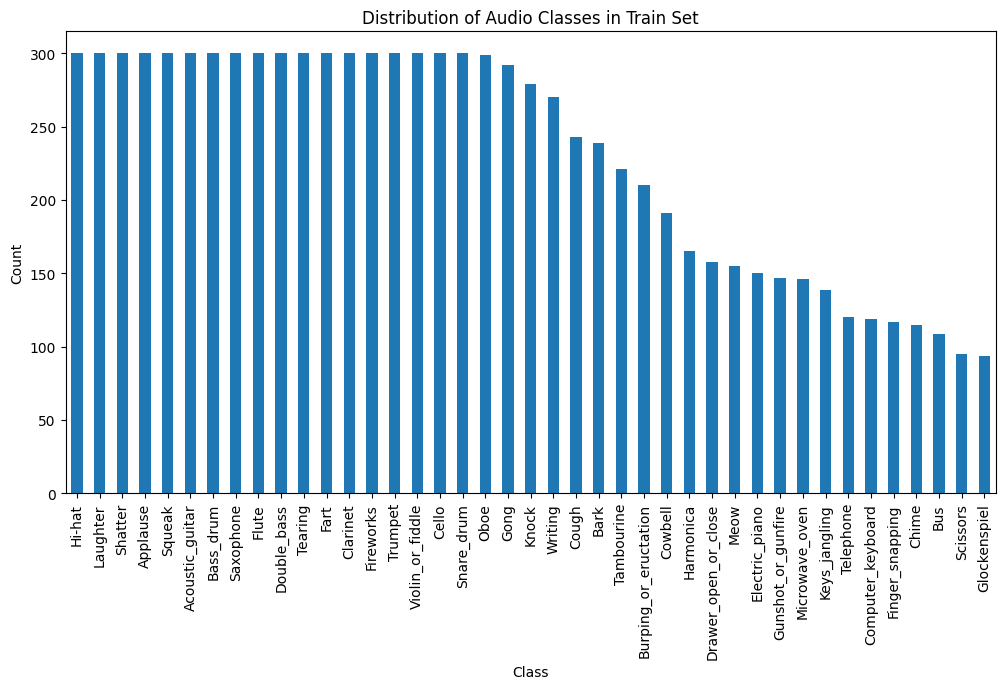

Total files analyzed: 9473
Mean duration: 6.79 sec
Max duration: 30.00 sec
Min duration: 0.30 sec


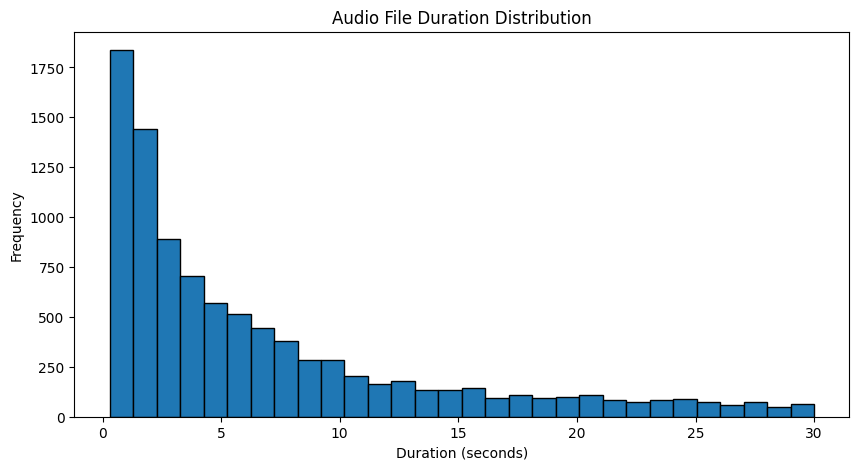

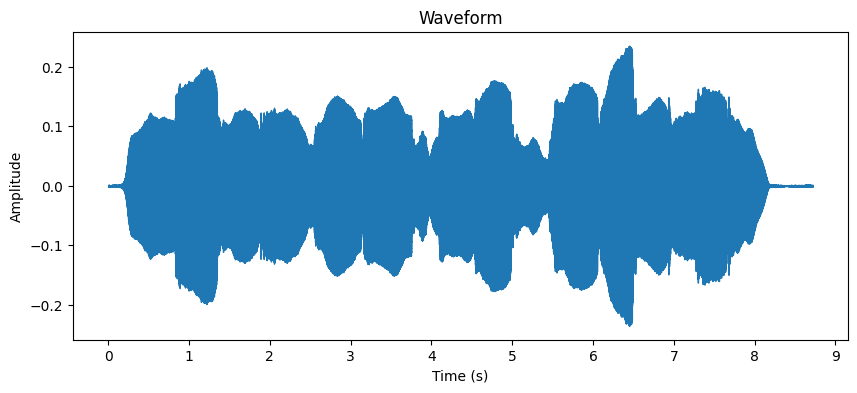

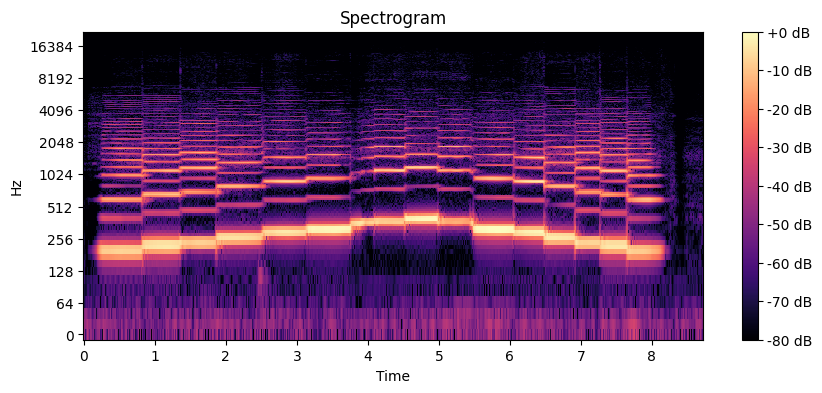

Test Dataset Analysis
Total files analyzed: 1600
Mean duration: 5.20 sec
Max duration: 29.74 sec
Min duration: 0.30 sec


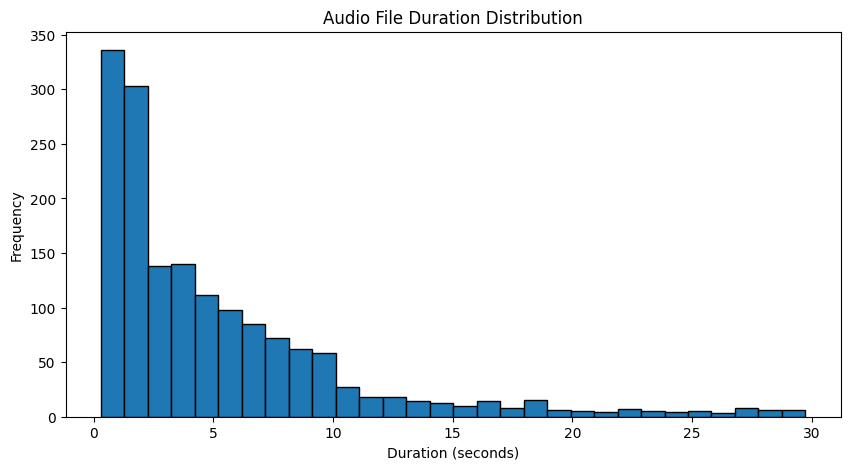

In [5]:

# function to compute basic statistics
def compute_audio_statistics(audio_dir):
    durations = []
    for file in os.listdir(audio_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(audio_dir, file)
            y, sr = librosa.load(file_path, sr=None)
            durations.append(librosa.get_duration(y=y, sr=sr))
    
    if durations:
        print(f"Total files analyzed: {len(durations)}")
        print(f"Mean duration: {np.mean(durations):.2f} sec")
        print(f"Max duration: {np.max(durations):.2f} sec")
        print(f"Min duration: {np.min(durations):.2f} sec")
        
        plt.figure(figsize=(10, 5))
        plt.hist(durations, bins=30, edgecolor='black')
        plt.xlabel("Duration (seconds)")
        plt.ylabel("Frequency")
        plt.title("Audio File Duration Distribution")
        plt.show()
    else:
        print("No audio files found in the directory.")

# run EDA
if os.path.exists(train_path):
    print("Train Dataset Analysis")
    if train_df is not None:
        get_class_distribution(train_df)
    compute_audio_statistics(train_path)
    sample_audio = np.random.choice([f for f in os.listdir(train_path) if f.endswith(".wav")])
    visualize_audio(os.path.join(train_path, sample_audio))

if os.path.exists(test_path):
    print("Test Dataset Analysis")
    compute_audio_statistics(test_path)


In [6]:
!pip install librosa matplotlib pandas numpy torch torchvision torchaudio


In [7]:
# Ddefine Audio Dataset Class
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        y, sr = librosa.load(self.file_paths[idx], sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return torch.tensor(mfccs, dtype=torch.float32).unsqueeze(0), torch.tensor(self.labels[idx], dtype=torch.long)

# Prrepare dataset
if train_df is not None:
    train_files = [os.path.join(train_path, f) for f in train_df["filename"]]
    train_labels = train_df["label"].tolist()
    train_dataset = AudioDataset(train_files, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Ffunction to train model
def train_model(model, dataloader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for data, labels in dataloader:
            data = data.view(data.shape[0], -1)
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}, Accuracy: {correct/total:.4f}")
    return correct / total

# function to apply JointMatch
def apply_jointmatch(train_loader):
    print("Applying JointMatch on the dataset...")
    model = nn.Sequential(
        nn.Linear(40 * 32, 256),
        nn.ReLU(),
        nn.Linear(256, 41),
        nn.Softmax(dim=1)
    )
    accuracy = train_model(model, train_loader)
    print("JointMatch Training Complete with Accuracy:", accuracy)
    return accuracy

# function to apply EPASS
def apply_epass(train_loader):
    print("Applying EPASS on the dataset...")
    model = nn.Sequential(
        nn.Linear(40 * 32, 256),
        nn.ReLU(),
        nn.Linear(256, 41),
        nn.Softmax(dim=1)
    )
    accuracy = train_model(model, train_loader)
    print("EPASS Training Complete with Accuracy:", accuracy)
    return accuracy

# function to compare results
def compare_results(jointmatch_results, epass_results):
    print("Comparing JointMatch and EPASS results...")
    print(f"JointMatch Accuracy: {jointmatch_results}")
    print(f"EPASS Accuracy: {epass_results}")
    if epass_results > jointmatch_results:
        print("EPASS performed better.")
    else:
        print("JointMatch performed better.")
train_files = [os.path.join(train_path, f) for f in train_df["filename"]]
train_labels = train_df["label"].tolist()
train_dataset = AudioDataset(train_files, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

jointmatch_results = apply_jointmatch(train_loader)
epass_results = apply_epass(train_loader)
compare_results(jointmatch_results, epass_results)


KeyError: 'filename'